In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

In [31]:
labels = ['Abyssinian', 'American', "Silkie", 'Skinny']

In [2]:
train_data = pd.read_csv("./data/cavy_data_train.csv")
val_data = pd.read_csv("./data/cavy_data_val.csv")
test_data = pd.read_csv("./data/cavy_data_test.csv")

In [33]:
train_data.head()

,image_path,breed
0,images/American/american_2143.jpg,American
1,images/American/piggy_301.jpg,American
2,images/Abyssinian/abyssinian_1653.jpg,Abyssinian
3,images/Abyssinian/abyssinian_1318.jpg,Abyssinian
4,images/American/american_212.jpg,American


In [34]:
path, label = train_data["image_path"], train_data["breed"]


In [35]:
class cherry_dataset(Dataset):
    def __init__(self, csv_path, transform = None):
        self.dataframe = pd.read_csv(csv_path)
        images, self.labels = self.dataframe["image_path"], self.dataframe["breed"]
        self.image_set = []
        for image in images:
            image_file = cv2.imread( image)
            image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
            image_file = cv2.resize(image_file, (300, 300))
            self.image_set.append(image_file)
            
        self.image_set = np.array(self.image_set)
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.image_set[idx]
        label = self.labels[idx]
        if label == "Skinny":
            label = 0
        elif label == "Abyssinian":
            label = 1
        elif label == "American":
            label = 2
        else:
            label = 3
        if self.transform:
            sample = self.transform(image), label
        else:
            sample = iamge, label
            
        return sample

In [36]:
train_transform = transform = T.Compose([
                
                T.ToTensor(),
                T.CenterCrop(250),
                T.RandomCrop(224),
                T.RandomHorizontalFlip(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
            ])

train_set = cherry_dataset(csv_path = "./data/cavy_data_train.csv", transform=train_transform)
val_set = cherry_dataset(csv_path = "./data/cavy_data_val.csv", transform=transform)
test_set = cherry_dataset(csv_path = "./data/cavy_data_test.csv", transform=transform)
batch_size = 16
loader_train = DataLoader(train_set, batch_size = batch_size,shuffle = True)
loader_val = DataLoader(val_set, batch_size = batch_size, shuffle=False)
loader_test = DataLoader(test_set, batch_size = batch_size, shuffle=False)

In [37]:
USE_GPU = True
num_class = 4
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50

print('using device:', device)

using device: cuda


In [38]:
def check_accuracy(loader, model):
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [39]:
def trainer(model, optimizer, epoch = 10):
    model = model.to(device = device)
    accs_train = []
    accs_val = []
    accs_test = []
    for e in range(epoch):
#         num_correct = 0
#         num_samples = 0
        for batch_idx, (image, label) in enumerate(loader_train):
            model.train()
            image = image.to(device = device, dtype = dtype)
            label = label.to(device = device, dtype = torch.long)
            scores = model(image)
            #print(scores.shape)
            _, preds = scores.max(1)
            loss = F.cross_entropy(scores, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             num_correct += (preds == label).sum()
#             num_samples += preds.size(0)

            if batch_idx % print_every == 0:
                print("Epoch %d Iteration %d: Loss = %.4f" % (e, batch_idx, loss.item()))
                accs_train.append(check_accuracy(loader_train, model))
                accs_val.append(check_accuracy(loader_val, model))
                accs_test.append(check_accuracy(loader_test, model))
#                 acc = float(num_correct) / num_samples
#                 print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
                print()
    return accs_train, accs_val, accs_test

In [40]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


__all__ = ['SENet', 'se_resnet_18', 'se_resnet_34', 'se_resnet_50', 'se_resnet_101',
           'se_resnet_152']

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(in_features=planes, out_features=round(planes / 16))
        self.fc2 = nn.Linear(in_features=round(planes / 16), out_features=planes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        if planes == 64:
            self.globalAvgPool = nn.AvgPool2d(56, stride=1)
        elif planes == 128:
            self.globalAvgPool = nn.AvgPool2d(28, stride=1)
        elif planes == 256:
            self.globalAvgPool = nn.AvgPool2d(14, stride=1)
        elif planes == 512:
            self.globalAvgPool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(in_features=planes * 4, out_features=round(planes / 4))
        self.fc2 = nn.Linear(in_features=round(planes / 4), out_features=planes * 4)
        self.sigmoid = nn.Sigmoid()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        original_out = out
        out = self.globalAvgPool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.size(0),out.size(1),1,1)
        out = out * original_out

        out += residual
        out = self.relu(out)

        return out


class SENet(nn.Module):

    def __init__(self, block, layers, num_classes=4):
        self.inplanes = 64
        super(SENet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def se_resnet_18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SENet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [41]:
model = se_resnet_18(pretrained=True)
print(model)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0.01)
accs_train2, accs_val2, accs_test2 = trainer(model, optimizer, 100)

SENet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (globalAvgPool): AvgPool2d(kernel_size=56, stride=1, padding=0)
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
      (sigmoid): Sigmoid()
    )
    (1): BasicBlock(

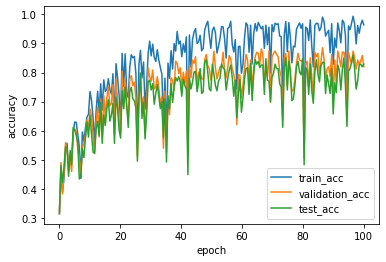

In [62]:
fig, ax = plt.subplots()
x = np.linspace(0, 100, 200)
ax.plot(x,accs_train2, label = "train_acc")
ax.plot(x, accs_val2, label = "validation_acc")
ax.plot(x, accs_test2, label = "test_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
ax.legend()
plt.savefig('SEnet_curve.png', dpi = 500)

In [46]:
import torchvision.models as models
resnet = models.resnet18(pretrained=False)
learning_rate = 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), lr = learning_rate, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0.01)
resnet.fc = nn.Linear(512,4)

accs_train_resnet, accs_val_resnet, accs_test_resnet = trainer(resnet, optimizer, 100)

Epoch 0 Iteration 0: Loss = 1.5722
Got 186 / 1043 correct (17.83)
Got 47 / 261 correct (18.01)
Got 59 / 327 correct (18.04)

Epoch 0 Iteration 50: Loss = 1.5500
Got 431 / 1043 correct (41.32)
Got 116 / 261 correct (44.44)
Got 126 / 327 correct (38.53)

Epoch 1 Iteration 0: Loss = 0.8411
Got 472 / 1043 correct (45.25)
Got 133 / 261 correct (50.96)
Got 157 / 327 correct (48.01)

Epoch 1 Iteration 50: Loss = 0.9017
Got 447 / 1043 correct (42.86)
Got 114 / 261 correct (43.68)
Got 137 / 327 correct (41.90)

Epoch 2 Iteration 0: Loss = 1.2382
Got 585 / 1043 correct (56.09)
Got 150 / 261 correct (57.47)
Got 189 / 327 correct (57.80)

Epoch 2 Iteration 50: Loss = 0.6828
Got 507 / 1043 correct (48.61)
Got 133 / 261 correct (50.96)
Got 173 / 327 correct (52.91)

Epoch 3 Iteration 0: Loss = 1.2838
Got 513 / 1043 correct (49.19)
Got 124 / 261 correct (47.51)
Got 152 / 327 correct (46.48)

Epoch 3 Iteration 50: Loss = 0.9120
Got 580 / 1043 correct (55.61)
Got 128 / 261 correct (49.04)
Got 180 / 327

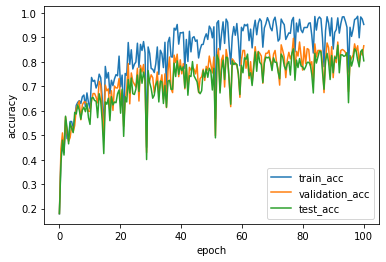

In [63]:

fig, ax = plt.subplots()
x = np.linspace(0, 100, 200)
ax.plot(x,accs_train_resnet, label = "train_acc")
ax.plot(x, accs_val_resnet, label = "validation_acc")
ax.plot(x, accs_test_resnet, label = "test_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
ax.legend()
plt.savefig('resnet_curve.png', dpi = 500)

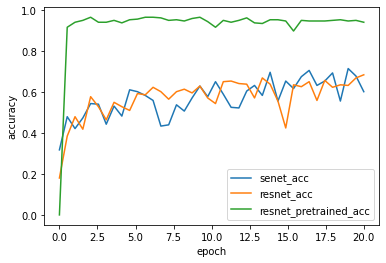

In [64]:
fig, ax = plt.subplots()
x = np.linspace(0, 20, 40)
ax.plot(x, accs_test2[0:40], label = "senet_acc")
ax.plot(x, accs_test_resnet[0:40], label = "resnet_acc")
ax.plot(x, accs_test_resnet_pretrained, label = "resnet_pretrained_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
ax.legend()
plt.savefig('senet vs resnet vs tranfer learning.png', dpi = 500)

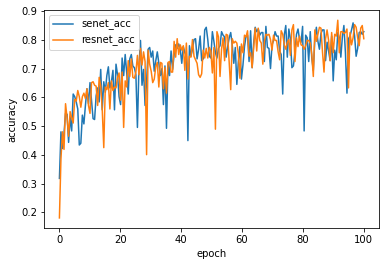

In [65]:
fig, ax = plt.subplots()
x = np.linspace(0, 100, 200)
ax.plot(x, accs_test2, label = "senet_acc")
ax.plot(x, accs_test_resnet, label = "resnet_acc")
#ax.plot(x, accs_test_resnet_pretrained, label = "resnet_pretrained_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
ax.legend()
plt.savefig('senet vs resnet.png', dpi = 500)

In [52]:
import torchvision.models as models
resnet_pretrained = models.resnet18(pretrained=True)
learning_rate = 1e-4
optimizer = torch.optim.Adam(resnet_pretrained.parameters(), lr = learning_rate, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0.01)
resnet.fc = nn.Linear(512,4)

accs_train_resnet_pretrained, accs_val_resnet_pretrained, accs_test_resnet_pretrained = trainer(resnet_pretrained, optimizer, 20)

Epoch 0 Iteration 0: Loss = 9.2039
Got 0 / 1043 correct (0.00)
Got 0 / 261 correct (0.00)
Got 0 / 327 correct (0.00)

Epoch 0 Iteration 50: Loss = 0.4050
Got 1008 / 1043 correct (96.64)
Got 247 / 261 correct (94.64)
Got 300 / 327 correct (91.74)

Epoch 1 Iteration 0: Loss = 0.0980
Got 1008 / 1043 correct (96.64)
Got 249 / 261 correct (95.40)
Got 308 / 327 correct (94.19)

Epoch 1 Iteration 50: Loss = 0.0239
Got 1031 / 1043 correct (98.85)
Got 253 / 261 correct (96.93)
Got 311 / 327 correct (95.11)

Epoch 2 Iteration 0: Loss = 0.7539
Got 1034 / 1043 correct (99.14)
Got 250 / 261 correct (95.79)
Got 316 / 327 correct (96.64)

Epoch 2 Iteration 50: Loss = 0.0554
Got 1027 / 1043 correct (98.47)
Got 252 / 261 correct (96.55)
Got 308 / 327 correct (94.19)

Epoch 3 Iteration 0: Loss = 0.0383
Got 1028 / 1043 correct (98.56)
Got 249 / 261 correct (95.40)
Got 308 / 327 correct (94.19)

Epoch 3 Iteration 50: Loss = 0.8985
Got 1035 / 1043 correct (99.23)
Got 252 / 261 correct (96.55)
Got 311 / 327

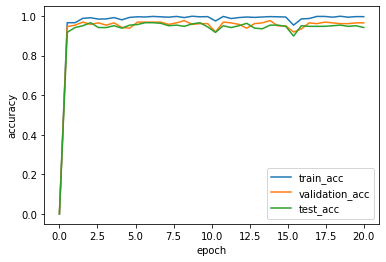

In [66]:
fig, ax = plt.subplots()
x = np.linspace(0, 20, 40)
ax.plot(x,accs_train_resnet_pretrained, label = "train_acc")
ax.plot(x, accs_val_resnet_pretrained, label = "validation_acc")
ax.plot(x, accs_test_resnet_pretrained, label = "test_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
ax.legend()
plt.savefig('resnet_pretrained_curve.png', dpi = 500)